# Analyze dynophores

## Aim of this notebook

Explore how to analyze dynophores in a Jupyter notebook!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import json
from pathlib import Path

import numpy as np
import pandas as pd

import dynophores

## Read data files

In [3]:
DATA = Path('../data/out/DynophoreApp')

In [4]:
dynophore_files = [file for file in DATA.glob('*')]
dynophore_files[:3]

[PosixPath('../data/out/DynophoreApp/1KE7-1_Data__superFeature_HBA[4619]%12.3.txt'),
 PosixPath('../data/out/DynophoreApp/1KE7-1_Data__superFeature_HBA[4618]%0.2.txt'),
 PosixPath('../data/out/DynophoreApp/1KE7-1_Data__superFeature_AR[4622,4615,4623,4613,4614,4621]%4.0.txt')]

### Json

In [5]:
# Initialize dynophore
dynophore = {'dynophore': []}

# Get superfeatures
superfeature_names = set([file.stem.split('_')[4].split('%')[0] for file in dynophore_files])

for superfeature_name in superfeature_names:
    
    # Get all files with this superfeature
    superfeature_files = [file for file in dynophore_files if superfeature_name in file.stem]
    
    # Get superfeature file
    assert len([file for file in superfeature_files if len(file.stem.split('_')) == 5]) == 1
    superfeature_file = [file for file in superfeature_files if len(file.stem.split('_')) == 5][0]
    
    # Set superfeature
    superfeature = {'name': superfeature_name, 'file': str(superfeature_file), 'env_partners': []}
    
    # Get environmental partner files for this superfeature
    for file in superfeature_files:
        if len(file.stem.split('_')) == 7:
            env_partner_file = file
            env_partner_name = env_partner_file.stem.split('_')[6].split('%')[0]
            env_partner = {'name': env_partner_name, 'file': str(env_partner_file)}
            superfeature['env_partners'].append(env_partner)
        
    dynophore['dynophore'].append(superfeature)

In [6]:
with open(DATA / '..' / 'dynophore_metadata.json', 'w') as f:
    json.dump(dynophore, f)

#### Superfeatures occurrence

In [7]:
occurrence_superfeatures = pd.concat(
    [pd.read_csv(superfeature['file'], header=None) for superfeature in dynophore['dynophore']], 
    axis=1
)
occurrence_superfeatures.columns = [superfeature['name'] for superfeature in dynophore['dynophore']]
occurrence_superfeatures.head()

,HBA[4606],"AR[4622,4615,4623,4613,4614,4621]",HBD[4598],HBA[4619],HBA[4618],"H[4599,4602,4601,4608,4609,4600]",HBD[4612],HBA[4596],"H[4615,4623,4622,4613,4621,4614]","AR[4605,4607,4603,4606,4604]"
0,0,0,0,1,0,1,0,1,1,0
1,0,0,0,1,0,1,0,1,1,0
2,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,1,1,0,1,0


In [8]:
type(occurrence_superfeatures.iloc[0, 0])

numpy.int64

In [9]:
def read_interactions(dynophore, type='occurrence'):
    
    types = ['occurrence', 'distance']
    if type == 'occurrence':
        type_ix = 1
    elif type == 'distance':
        type_ix = 0
    else:
        raise ValueError(f'Wrong type. Select from: {", ".join(types)}')
    
    interactions = defaultdict()

    for superfeature in dynophore['dynophore']:

        interaction = pd.concat(
            [pd.read_csv(env_partner['file'], header=None)[type_ix] for env_partner in superfeature['env_partners']], 
            axis=1
        )
        interaction.columns = [env_partner['name'] for env_partner in superfeature['env_partners']]
        interactions[superfeature['name']] = interaction

    return interactions

#### Interactions occurrence

In [10]:
interactions_occurrence = read_interactions(dynophore, type='occurrence')
print(interactions_occurrence.keys())
interactions_occurrence['HBD[4612]'].head()

dict_keys(['HBA[4606]', 'AR[4622,4615,4623,4613,4614,4621]', 'HBD[4598]', 'HBA[4619]', 'HBA[4618]', 'H[4599,4602,4601,4608,4609,4600]', 'HBD[4612]', 'HBA[4596]', 'H[4615,4623,4622,4613,4621,4614]', 'AR[4605,4607,4603,4606,4604]'])


,GLN-131-A[2061],ASP-86-A[1319],LEU-83-A[1263],GLN-131-A[2057],ASP-86-A[1320]
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,1,0,0


In [11]:
type(interactions_occurrence['HBD[4612]'].iloc[0, 0])

numpy.int64

#### Interactions distances

In [12]:
interactions_distance = read_interactions(dynophore, type='distance')
print(interactions_distance.keys())
interactions_distance['HBD[4612]'].head()

dict_keys(['HBA[4606]', 'AR[4622,4615,4623,4613,4614,4621]', 'HBD[4598]', 'HBA[4619]', 'HBA[4618]', 'H[4599,4602,4601,4608,4609,4600]', 'HBD[4612]', 'HBA[4596]', 'H[4615,4623,4622,4613,4621,4614]', 'AR[4605,4607,4603,4606,4604]'])


,GLN-131-A[2061],ASP-86-A[1319],LEU-83-A[1263],GLN-131-A[2057],ASP-86-A[1320]
0,11.944555,7.128676,3.427919,6.769520,8.252505
1,11.944555,7.128676,3.427919,6.769520,8.252505
2,12.278903,8.653643,3.582377,6.767191,7.264928
3,12.668950,7.213809,3.543346,7.105429,8.994092
4,12.911131,9.341150,3.175053,7.417255,7.662991


In [13]:
type(interactions_distance['HBD[4612]'].iloc[0, 0])

numpy.float64

### `Dynophore` instance

In [14]:
dynophore = dynophores.Dynophore()

In [15]:
dynophore._get_file_components(dynophore_files[0])

{'filepath': PosixPath('../data/out/DynophoreApp/1KE7-1_Data__superFeature_HBA[4619]%12.3.txt'),
 'dynophore_id': '1KE7-1',
 'superfeature_id': 'HBA[4619]',
 'superfeature_feature_type': 'HBA',
 'superfeature_atom_numbers': [4619],
 'envpartner_id': None,
 'envpartner_residue_name': None,
 'envpartner_residue_number': None,
 'envpartner_chain': None,
 'envpartner_atom_numbers': None}

In [16]:
dynophore.from_file(DATA)  

print(dynophore.id)
print(dynophore.superfeatures[2].id)
print(dynophore.superfeatures[2].feature_type)
print(dynophore.superfeatures[2].atom_numbers)
print(dynophore.superfeatures[2].occurrences)
print(dynophore.superfeatures[2].envpartners[0].id)
print(dynophore.superfeatures[2].envpartners[0].residue_name)
print(dynophore.superfeatures[2].envpartners[0].residue_number)
print(dynophore.superfeatures[2].envpartners[0].chain)
print(dynophore.superfeatures[2].envpartners[0].atom_numbers)
print(dynophore.superfeatures[2].envpartners[0].occurrences)
print(dynophore.superfeatures[2].envpartners[0].distances)

1KE7-1
AR[4622,4615,4623,4613,4614,4621]
AR
[4622, 4615, 4623, 4613, 4614, 4621]
[0 0 0 ... 0 0 0]
ILE-10-A[165]
ILE
10
A
[165]
[0 0 0 ... 0 0 0]
[7.1051545 7.1051545 7.267492  ... 0.        0.        0.       ]


#### `dynophore.superfeatures_occurrences`

In [17]:
dynophore.superfeatures_occurrences.head()

,HBA[4619],HBA[4618],"AR[4622,4615,4623,4613,4614,4621]","AR[4605,4607,4603,4606,4604]","H[4599,4602,4601,4608,4609,4600]",HBA[4596],HBD[4598],HBA[4606],"H[4615,4623,4622,4613,4621,4614]",HBD[4612]
0,1,0,0,0,1,1,0,0,1,0
1,1,0,0,0,1,1,0,0,1,0
2,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,1,1


#### `dynophore.envpartners_occurrences`

In [18]:
print(dynophore.envpartners_occurrences.keys())
dynophore.envpartners_occurrences['HBA[4619]'].head()

dict_keys(['HBA[4619]', 'HBA[4618]', 'AR[4622,4615,4623,4613,4614,4621]', 'AR[4605,4607,4603,4606,4604]', 'H[4599,4602,4601,4608,4609,4600]', 'HBA[4596]', 'HBD[4598]', 'HBA[4606]', 'H[4615,4623,4622,4613,4621,4614]', 'HBD[4612]'])


,LYS-20-A[308],LYS-20-A[316],ILE-10-A[165],ASP-86-A[1313]
0,0,0,0,1
1,0,0,0,1
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


#### `dynophore.envpartners_distances`

In [19]:
print(dynophore.envpartners_distances.keys())
dynophore.envpartners_distances['HBA[4619]'].head()

dict_keys(['HBA[4619]', 'HBA[4618]', 'AR[4622,4615,4623,4613,4614,4621]', 'AR[4605,4607,4603,4606,4604]', 'H[4599,4602,4601,4608,4609,4600]', 'HBA[4596]', 'HBD[4598]', 'HBA[4606]', 'H[4615,4623,4622,4613,4621,4614]', 'HBD[4612]'])


,LYS-20-A[308],LYS-20-A[316],ILE-10-A[165],ASP-86-A[1313]
0,12.086337,10.283849,10.234147,2.995031
1,12.086337,10.283849,10.234147,2.995031
2,10.457222,9.915476,8.992463,5.948585
3,10.351493,8.698255,9.028577,6.975447
4,10.532646,10.217158,9.939754,5.173286


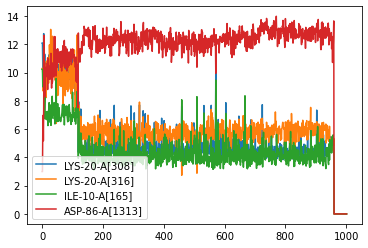

In [20]:
dynophore.envpartners_distances['HBA[4619]'].plot()

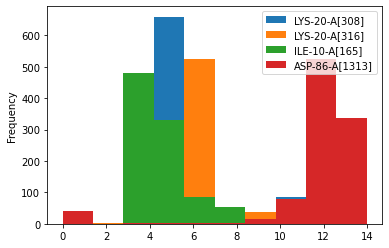

In [21]:
dynophore.envpartners_distances['HBA[4619]'].plot(kind='hist')

#### `superfeature.envpartners_occurrences`

In [22]:
dynophore.superfeatures[0].envpartners_occurrences.head()

,LYS-20-A[308],LYS-20-A[316],ILE-10-A[165],ASP-86-A[1313]
0,0,0,0,1
1,0,0,0,1
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


#### `superfeature.envpartners_distances`

In [23]:
sum(np.array([1,2]))

3

In [24]:
dynophore.superfeatures[0].envpartners_distances.head()

,LYS-20-A[308],LYS-20-A[316],ILE-10-A[165],ASP-86-A[1313]
0,12.086337,10.283849,10.234147,2.995031
1,12.086337,10.283849,10.234147,2.995031
2,10.457222,9.915476,8.992463,5.948585
3,10.351493,8.698255,9.028577,6.975447
4,10.532646,10.217158,9.939754,5.173286


#### `n_frames`, `count`, and `frequency`

##### Dynophore

In [25]:
dynophore.n_frames

1002

In [26]:
dynophore.count

,HBA[4619],HBA[4618],"AR[4622,4615,4623,4613,4614,4621]","AR[4605,4607,4603,4606,4604]","H[4599,4602,4601,4608,4609,4600]",HBA[4596],HBD[4598],HBA[4606],"H[4615,4623,4622,4613,4621,4614]",HBD[4612]
"ALA-144-A[2263,2266]",0,0,0,0,992,0,0,0,0,0
"ALA-31-A[488,491]",0,0,0,0,216,0,0,0,0,0
ASP-86-A[1313],2,0,0,0,0,0,0,0,0,0
ASP-86-A[1319],0,0,0,0,0,0,0,0,0,18
ASP-86-A[1320],0,0,0,0,0,0,0,0,0,20
GLN-131-A[2057],0,0,0,0,0,0,0,0,0,1
GLN-131-A[2061],0,0,0,0,0,0,0,0,0,8
GLN-131-A[2062],0,0,0,0,0,0,0,2,0,0
GLU-81-A[1228],0,0,0,0,0,0,8,0,0,0
"HIS-84-A[1284,1285,1286,1287,1288]",0,0,1,0,0,0,0,0,0,0


In [27]:
dynophore.frequency

,HBA[4619],HBA[4618],"AR[4622,4615,4623,4613,4614,4621]","AR[4605,4607,4603,4606,4604]","H[4599,4602,4601,4608,4609,4600]",HBA[4596],HBD[4598],HBA[4606],"H[4615,4623,4622,4613,4621,4614]",HBD[4612]
"ALA-144-A[2263,2266]",0.00,0.0,0.00,0.0,99.00,0.00,0.0,0.0,0.00,0.00
"ALA-31-A[488,491]",0.00,0.0,0.00,0.0,21.56,0.00,0.0,0.0,0.00,0.00
ASP-86-A[1313],0.20,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
ASP-86-A[1319],0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,1.80
ASP-86-A[1320],0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,2.00
GLN-131-A[2057],0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.10
GLN-131-A[2061],0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.80
GLN-131-A[2062],0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.2,0.00,0.00
GLU-81-A[1228],0.00,0.0,0.00,0.0,0.00,0.00,0.8,0.0,0.00,0.00
"HIS-84-A[1284,1285,1286,1287,1288]",0.00,0.0,0.10,0.0,0.00,0.00,0.0,0.0,0.00,0.00


In [28]:
sns.heatmap(dynophore.frequency, cmap='Blues')

NameError: name 'sns' is not defined

##### Superfeatures

In [ ]:
dynophore.superfeatures[0].n_frames

In [ ]:
dynophore.superfeatures[0].count

In [ ]:
dynophore.superfeatures[0].frequency

##### Environmental partners

In [ ]:
dynophore.superfeatures[0].envpartners[2].n_frames

In [ ]:
dynophore.superfeatures[0].envpartners[2].count

In [ ]:
dynophore.superfeatures[0].envpartners[2].frequency